In [38]:
import sknetwork as sn
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
from sklearn.metrics import f1_score as F1
from sklearn.metrics import roc_auc_score as AUC
from egosplit_sknetwork import EgoSplit
from partition_sknetwork import ECG
import matplotlib.pyplot as plt
import seaborn as sns
import numba

import os

import CAS
import community_evaluation as ce

In [6]:
# We tend to get divide by 0 warnings, but they are corretly set to inf
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [7]:
# Function to handle building ABCD+oo graphs with the julia library
# Requires julia to be installed and ABCDGraphGenerator.jl to be added.

abcd_path = "~/Research/ABCDGraphGenerator.jl/utils/"
this_path = "~/Research/CAS/experiments/"
julia = "julia "


def _run_julia_abcd(
    n,
    xi,
    eta,
    nout,
    rng=None,
    gamma=2.5,
    delta=5,
    Delta=None,
    s=50,
    S=None,
    beta=1.5,
    d=8,
    rho=0.0,
):
    if rng is None:
        rng = np.random.default_rng()
    rdm = str(rng.choice(100000))
    if Delta is None:
        Delta = int(n**0.5)
    if S is None:
        S = int(n**0.767)
    if nout <= 0:
        raise ValueError("Cannot parse without outliers")

    config = f"""seed = "{rdm}"                   # RNG seed, use "" for no seeding
n = "{n}"                   # number of vertices in graph
nout = "{nout}"                  # number of vertices in graph that are outliers
t1 = "{gamma}"                      # power-law exponent for degree distribution
d_min = "{delta}"                   # minimum degree
d_max = "{Delta}"                  # maximum degree
d_max_iter = "1000"           # maximum number of iterations for sampling degrees
t2 = "{beta}"                      # power-law exponent for cluster size distribution
c_min = "{s}"                  # minimum cluster size after growing
c_max = "{S}"                # maximum cluster size after growing
c_max_iter = "1000"           # maximum number of iterations for sampling cluster sizes
xi = "{xi}"                    # fraction of edges to fall in background graph
eta = "{eta}"                   # average number of community per community node
d = "{d}"                       # dimensionality of latent space
rho = "{rho}"                   # correlation between degree and number of communities node is in
degreefile = "deg_{rdm}.dat"        # name of file do generate that contains vertex degrees
communitysizesfile = "cs_{rdm}.dat" # name of file do generate that contains community sizes
communityfile = "com_{rdm}.dat"     # name of file do generate that contains assignments of vertices to communities
networkfile = "edge_{rdm}.dat" """
    config_file = f"config_{rdm}.dat"
    with open(config_file, "w") as f:
        print(config, file=f)
    cmd = julia + abcd_path + "abcd_oo_sampler.jl " + this_path + config_file
    os.system(cmd + " >/dev/null 2>&1")

    adjacency = sn.data.from_csv(f"edge_{rdm}.dat")
    adjacency = adjacency[1:][:, 1:]
    list_of_coms = []
    n_coms = 0
    with open(f"com_{rdm}.dat", "r") as file:
        for line in file:
            # each line has the format: node_id\t[a,b,c]\n
            # for this node belonging to communities a,b,c
            # if there are outliers then they have community [-1]
            # node_id counts up starting at 0
            x = line.split("\t")[1].rstrip()[1:-1]  # gets a,b,c
            x_coms = [int(y) for y in x.split(",")]
            list_of_coms.append(np.array(x_coms))
            n_coms = max(n_coms, max(x_coms) - 1)

    labels = sp.lil_matrix((adjacency.shape[0], n_coms), dtype="bool")
    for x, x_coms in enumerate(list_of_coms):
        if x_coms[0] == 1:
            continue
        labels[x, x_coms - 2] = True
    labels = labels.transpose().tocsr()

    cmd = f"rm *_{rdm}.dat"
    os.system(cmd + " >/dev/null 2>&1")

    return adjacency, labels

# Quality Test

Test the AUC of each CAS score vs. actually belonging to the cluster using the real labels.

In [30]:
@numba.njit
def _get_cas_work(
    n_labels,
    labels_indptr,
    labels_indices,
    adjacency_indptr,
    adjacency_indices,
    adjacency_data,
):
    node_labels = CAS.cas_._make_node_label_sets(
        labels_indptr, labels_indices, len(adjacency_indptr) - 1
    )
    graph_volume = np.sum(adjacency_data)
    # Cache label volumes
    label_volumes = np.zeros(n_labels, dtype="float32")
    for node, nl in enumerate(node_labels):
        degree = CAS.cas_._get_degree(
            node, adjacency_indptr, adjacency_indices, adjacency_data
        )
        for label in nl:
            label_volumes[label] += degree
    assert graph_volume > 0
    label_volumes /= graph_volume

    # Compute Scores
    iefs = numba.typed.List.empty_list(numba.types.float64[:])
    niefs = numba.typed.List.empty_list(numba.types.float64[:])
    ps = numba.typed.List.empty_list(numba.types.float64[:])
    results = numba.typed.List.empty_list(numba.types.bool[:])

    for node, labels in enumerate(node_labels):
        plausible_labels = labels.copy()
        plausible_labels = node_labels[node].copy()
        neighbors = adjacency_indices[
            adjacency_indptr[node] : adjacency_indptr[node + 1]
        ]
        for neighbor in neighbors:
            plausible_labels.update(node_labels[neighbor])
        plausible_labels = list(plausible_labels)
        result = np.empty(len(plausible_labels), dtype="bool")
        ief = np.empty(len(plausible_labels), dtype="float64")
        nief = np.empty(len(plausible_labels), dtype="float64")
        p = np.empty(len(plausible_labels), dtype="float64")
        for i, label in enumerate(plausible_labels):
            result[i] = label in labels
            ief[i] = CAS.cas_._ief(
                node,
                label,
                label_volumes[label],
                node_labels,
                adjacency_indptr,
                adjacency_indices,
                adjacency_data,
            )
            nief[i] = CAS.cas_._nief(
                node,
                label,
                label_volumes[label],
                node_labels,
                adjacency_indptr,
                adjacency_indices,
                adjacency_data,
            )
            p[i] = CAS.cas_._p(
                node,
                label,
                label_volumes[label],
                node_labels,
                adjacency_indptr,
                adjacency_indices,
                adjacency_data,
            )
        results.append(result)
        iefs.append(ief)
        niefs.append(nief)
        ps.append(p)

    return results, iefs, niefs, ps


def get_cas_and_result(labels, adjacency):
    # Assume labels is a numpy array of a partition
    # return a numpy array with the cas score to each label
    labels_matrix = labels.tocsc()
    r, i, n, p = _get_cas_work(
        labels.shape[0],
        labels_matrix.indptr,
        labels_matrix.indices,
        adjacency.indptr,
        adjacency.indices,
        adjacency.data,
    )
    return np.hstack(r), np.hstack(i), np.hstack(n), np.hstack(p)

Text(0.5, 0.98, 'AUC for Community Membership on ABCD+o$^2$')

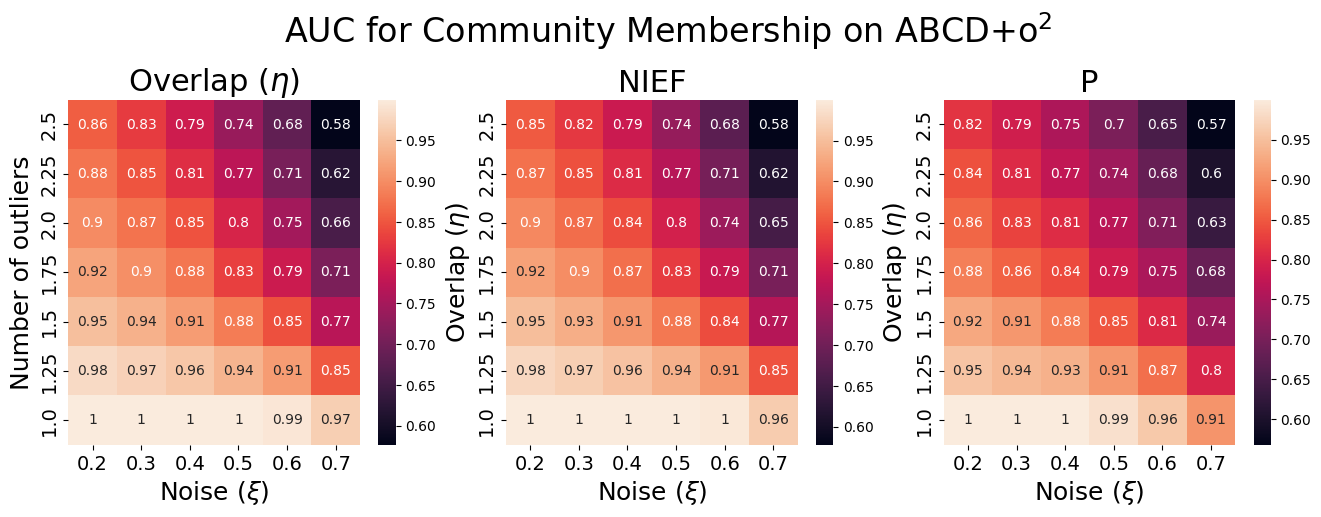

In [47]:
## For each CAS, make a heatmap of average AUC score
REP = 5
n = 10000
XIS = np.round(np.linspace(0.2, 0.7, 6), 2)
ETAS = np.round(np.linspace(1.0, 2.5, 7), 2)
nout = int(n / 5)

ief_aucs = np.empty((len(XIS), len(ETAS), REP))
nief_aucs = np.empty((len(XIS), len(ETAS), REP))
p_aucs = np.empty((len(XIS), len(ETAS), REP))
with tqdm(total=len(XIS) * len(ETAS) * REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, eta in enumerate(ETAS):
            for k in range(REP):
                adjacency, labels = _run_julia_abcd(n, xi, eta, nout)
                res, ief, nief, p = get_cas_and_result(labels, adjacency)
                ief_aucs[i, j, k] = AUC(res, ief)
                nief_aucs[i, j, k] = AUC(res, nief)
                p_aucs[i, j, k] = AUC(res, p)
                pbar.update()

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(top=0.8)  # Make room for suptitle

sns.heatmap(
    np.flip(np.mean(ief_aucs, axis=2), axis=1).T,
    xticklabels=XIS,
    yticklabels=ETAS[::-1],
    annot=True,
    ax=axs[0],
)
axs[0].set_xlabel(r"Noise ($\xi$)", fontsize=18)
axs[0].set_ylabel("Number of outliers", fontsize=18)
axs[0].tick_params(labelsize=14)
axs[0].set_title(r"Overlap ($\eta$)", fontsize=22)

sns.heatmap(
    np.flip(np.mean(nief_aucs, axis=2), axis=1).T,
    xticklabels=XIS,
    yticklabels=ETAS[::-1],
    annot=True,
    ax=axs[1],
)
axs[1].set_xlabel(r"Noise ($\xi$)", fontsize=18)
axs[1].set_ylabel(r"Overlap ($\eta$)", fontsize=18)
axs[1].tick_params(labelsize=14)
axs[1].set_title("NIEF", fontsize=22)

sns.heatmap(
    np.flip(np.mean(p_aucs, axis=2), axis=1).T,
    xticklabels=XIS,
    yticklabels=ETAS[::-1],
    annot=True,
    ax=axs[2],
)
axs[2].set_xlabel(r"Noise ($\xi$)", fontsize=18)
axs[2].set_ylabel(r"Overlap ($\eta$)", fontsize=18)
axs[2].tick_params(labelsize=14)
axs[2].set_title("P", fontsize=22)

plt.suptitle(r"AUC for Community Membership on ABCD+o$^2$", fontsize=24, y=0.98)
# fig.set_dpi(200)
# fig.savefig("outlier-aucs.png", bbox_inches="tight")

# Threshold effect on ABCD+o2 benchmark
Test the effect of choosing a threshold from pruning on ABCD+o2 graphs.
We hope to see that increaseing the threshold results in more outliers and a more correct non-oulier clustering.

In [9]:
REP = 10
n = 10000
ief_thresholds = np.linspace(0.1, 0.6, 10)
p_thresholds = np.linspace(0.9, 0.999, 10)

# Store (Cluster F1s, % Outlier, F1) in first axis, theshold in second axis, REP in third axis
ief = np.zeros((2, 3, len(ief_thresholds), REP))
nief = np.zeros((2, 3, len(ief_thresholds), REP))
p = np.zeros((2, 3, len(p_thresholds), REP))
ecg = np.zeros((2, 3, len(ief_thresholds), REP))

with tqdm(total=len(ief_thresholds) * REP * 8) as pbar:
    for i in range(REP):
        adjacency, labels = _run_julia_abcd(n, 0.3, 1.5, int(n / 5), rng=None)
        is_outlier = labels.getnnz(0) == 0
        ecgo = ECG()
        ecgo.fit_predict(adjacency)
        predict = EgoSplit(local_clustering="PC", global_clustering=ECG()).fit_predict(
            adjacency
        )

        for j, (t1, t2) in enumerate(zip(ief_thresholds, p_thresholds)):
            cas_predict = CAS.CASPostProcesser(
                score="ief", threshold=t1, only_remove=False
            ).fit_predict(predict, adjacency)
            ief[0, 1, j, i] = np.sum(cas_predict.getnnz(0) == 0) / n
            ief[0, 2, j, i] = F1(
                is_outlier, cas_predict.getnnz(0) == 0, zero_division=0.0
            )
            ief[0, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            pbar.update()

            cas_predict = CAS.CASPostProcesser(
                score="ief", threshold=t1, only_remove=False, max_rounds=1
            ).fit_predict(predict, adjacency)
            ief[1, 1, j, i] = np.sum(cas_predict.getnnz(0) == 0) / n
            ief[1, 2, j, i] = F1(
                is_outlier, cas_predict.getnnz(0) == 0, zero_division=0.0
            )
            ief[1, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            pbar.update()

            cas_predict = CAS.CASPostProcesser(
                score="nief", threshold=t1, only_remove=False
            ).fit_predict(predict, adjacency)
            nief[0, 1, j, i] = np.sum(cas_predict.getnnz(0) == 0) / n
            nief[0, 2, j, i] = F1(
                is_outlier, cas_predict.getnnz(0) == 0, zero_division=0.0
            )
            nief[0, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            pbar.update()

            cas_predict = CAS.CASPostProcesser(
                score="nief", threshold=t1, only_remove=False, max_rounds=1
            ).fit_predict(predict, adjacency)
            nief[1, 1, j, i] = np.sum(cas_predict.getnnz(0) == 0) / n
            nief[1, 2, j, i] = F1(
                is_outlier, cas_predict.getnnz(0) == 0, zero_division=0.0
            )
            nief[1, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            pbar.update()

            cas_predict = CAS.CASPostProcesser(
                score="p", threshold=t2, only_remove=False
            ).fit_predict(predict, adjacency)
            p[0, 1, j, i] = np.sum(cas_predict.getnnz(0) == 0) / n
            p[0, 2, j, i] = F1(
                is_outlier, cas_predict.getnnz(0) == 0, zero_division=0.0
            )
            p[0, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            pbar.update()

            cas_predict = CAS.CASPostProcesser(
                score="p", threshold=t2, only_remove=False, max_rounds=1
            ).fit_predict(predict, adjacency)
            p[1, 1, j, i] = np.sum(cas_predict.getnnz(0) == 0) / n
            p[1, 2, j, i] = F1(
                is_outlier, cas_predict.getnnz(0) == 0, zero_division=0.0
            )
            p[1, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            pbar.update()

            cas_predict = CAS.CASPostProcesser(
                score="ief", threshold=t1, only_remove=False
            ).fit_predict(predict, ecgo.weights)
            ecg[0, 1, j, i] = np.sum(cas_predict.getnnz(0) == 0) / n
            ecg[0, 2, j, i] = F1(
                is_outlier, cas_predict.getnnz(0) == 0, zero_division=0.0
            )
            ecg[0, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            pbar.update()

            cas_predict = CAS.CASPostProcesser(
                score="ief", threshold=t1, only_remove=False, max_rounds=1
            ).fit_predict(predict, ecgo.weights)
            ecg[1, 1, j, i] = np.sum(cas_predict.getnnz(0) == 0) / n
            ecg[1, 2, j, i] = F1(
                is_outlier, cas_predict.getnnz(0) == 0, zero_division=0.0
            )
            ecg[1, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            pbar.update()

 39%|███▉      | 312/800 [06:16<09:48,  1.21s/it] 


SystemError: CPUDispatcher(<function _post_process at 0x12e0734c0>) returned a result with an exception set

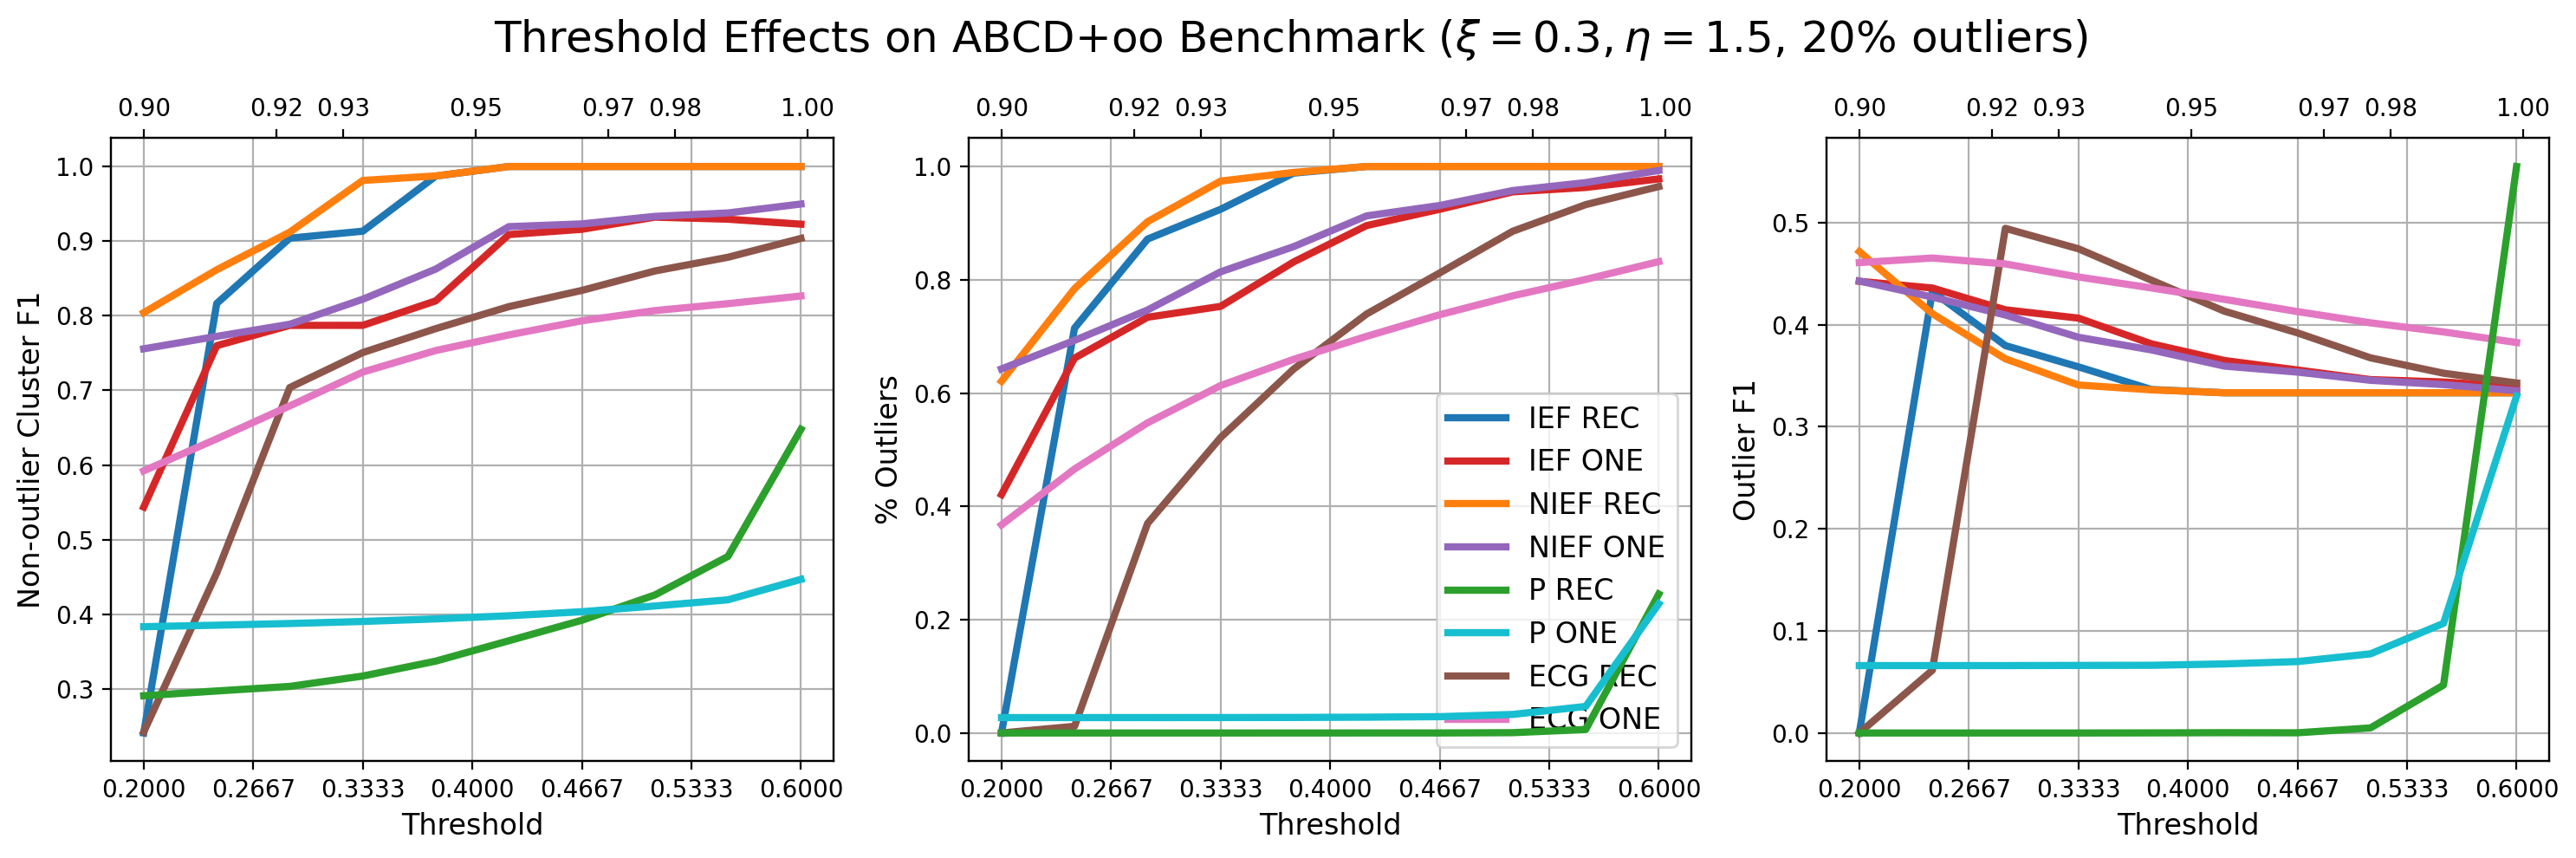

In [8]:
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:cyan",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
]

fig, axs = plt.subplots(1, 3)
for i in range(3):
    lines = []
    twy = axs[i].twiny()

    lines += axs[i].plot(
        ief_thresholds,
        np.mean(ief[0, i, :, :], axis=1),
        linewidth=3,
        label="IEF REC",
        c=colors[0],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(ief[1, i, :, :], axis=1),
        linewidth=3,
        label="IEF ONE",
        c=colors[3],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(nief[0, i, :, :], axis=1),
        linewidth=3,
        label="NIEF REC",
        c=colors[1],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(nief[1, i, :, :], axis=1),
        linewidth=3,
        label="NIEF ONE",
        c=colors[4],
    )
    lines += twy.plot(
        p_thresholds,
        np.mean(p[0, i, :, :], axis=1),
        label="P REC",
        linewidth=3,
        c=colors[2],
    )
    lines += twy.plot(
        p_thresholds,
        np.mean(p[1, i, :, :], axis=1),
        label="P ONE",
        linewidth=3,
        c=colors[5],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(ecg[0, i, :, :], axis=1),
        linewidth=3,
        label="ECG REC",
        c=colors[6],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(ecg[1, i, :, :], axis=1),
        linewidth=3,
        label="ECG ONE",
        c=colors[7],
    )
    labels = [l.get_label() for l in lines]

    # Align tick marks, 5 looks good
    n_ticks = 7
    ief_ticks = np.linspace(np.min(ief_thresholds), np.max(ief_thresholds), n_ticks)
    axs[i].set_xticks(ief_ticks)
    p_ticks = np.round(np.linspace(np.min(p_thresholds), 1, n_ticks), 2)
    twy.set_xticks(p_ticks)
    axs[i].grid()
    # axs[i].set_ylim((-0.01,1.01))

axs[0].set_ylabel("Non-outlier Cluster F1", fontsize=12)
axs[1].set_ylabel("% Outliers", fontsize=12)
axs[2].set_ylabel("Outlier F1", fontsize=12)
axs[0].set_xlabel("Threshold", fontsize=12)
axs[1].set_xlabel("Threshold", fontsize=12)
axs[2].set_xlabel("Threshold", fontsize=12)
axs[1].legend(lines, labels, fontsize=12)
plt.suptitle(
    f"Threshold Effects on ABCD+oo Benchmark " + r"$(\xi=0.3, \eta=1.5$, 20% outliers)",
    fontsize=18,
)

fig = plt.gcf()
fig.set_size_inches(15, 5)
fig.set_dpi(200)
fig.tight_layout()

# Test the threshold vs. overall clustering similarity
3 Heatmaps of xi vs threshold measureing overall F1 cluster similarity

In [22]:
REP = 5
n = 10000
NOUTS = [int(n / 5)]
XIS = np.round(np.linspace(0.1, 0.5, 10), 2)
ief_thresholds = np.round(np.linspace(0.1, 0.5, 10), 2)
p_thresholds = np.round(np.linspace(0.9, 0.99, 10), 2)


ief_f1s = np.empty((len(XIS), len(ief_thresholds), len(NOUTS), REP))
nief_f1s = np.empty((len(XIS), len(ief_thresholds), len(NOUTS), REP))
p_f1s = np.empty((len(XIS), len(p_thresholds), len(NOUTS), REP))

with tqdm(total=len(NOUTS) * len(XIS) * len(ief_thresholds) * REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                adjacency, labels = _run_julia_abcd(n, xi, 1.5, int(n / 5), rng=None)
                predict = EgoSplit(
                    local_clustering="PC", global_clustering=ECG()
                ).fit_predict(adjacency)
                for l, (t1, t2) in enumerate(zip(ief_thresholds, p_thresholds)):
                    cas_predict = CAS.CASPostProcesser(
                        score="ief", threshold=t1
                    ).fit_predict(predict, adjacency)
                    ief_f1s[i, l, j, k] = ce.cluster_f1s(labels, cas_predict)

                    cas_predict = CAS.CASPostProcesser(
                        score="nief", threshold=t1
                    ).fit_predict(predict, adjacency)
                    nief_f1s[i, l, j, k] = ce.cluster_f1s(labels, cas_predict)

                    cas_predict = CAS.CASPostProcesser(
                        score="p", threshold=t2
                    ).fit_predict(predict, adjacency)
                    p_f1s[i, l, j, k] = ce.cluster_f1s(labels, cas_predict)

                    pbar.update()

100%|██████████| 500/500 [42:16<00:00,  5.07s/it]   


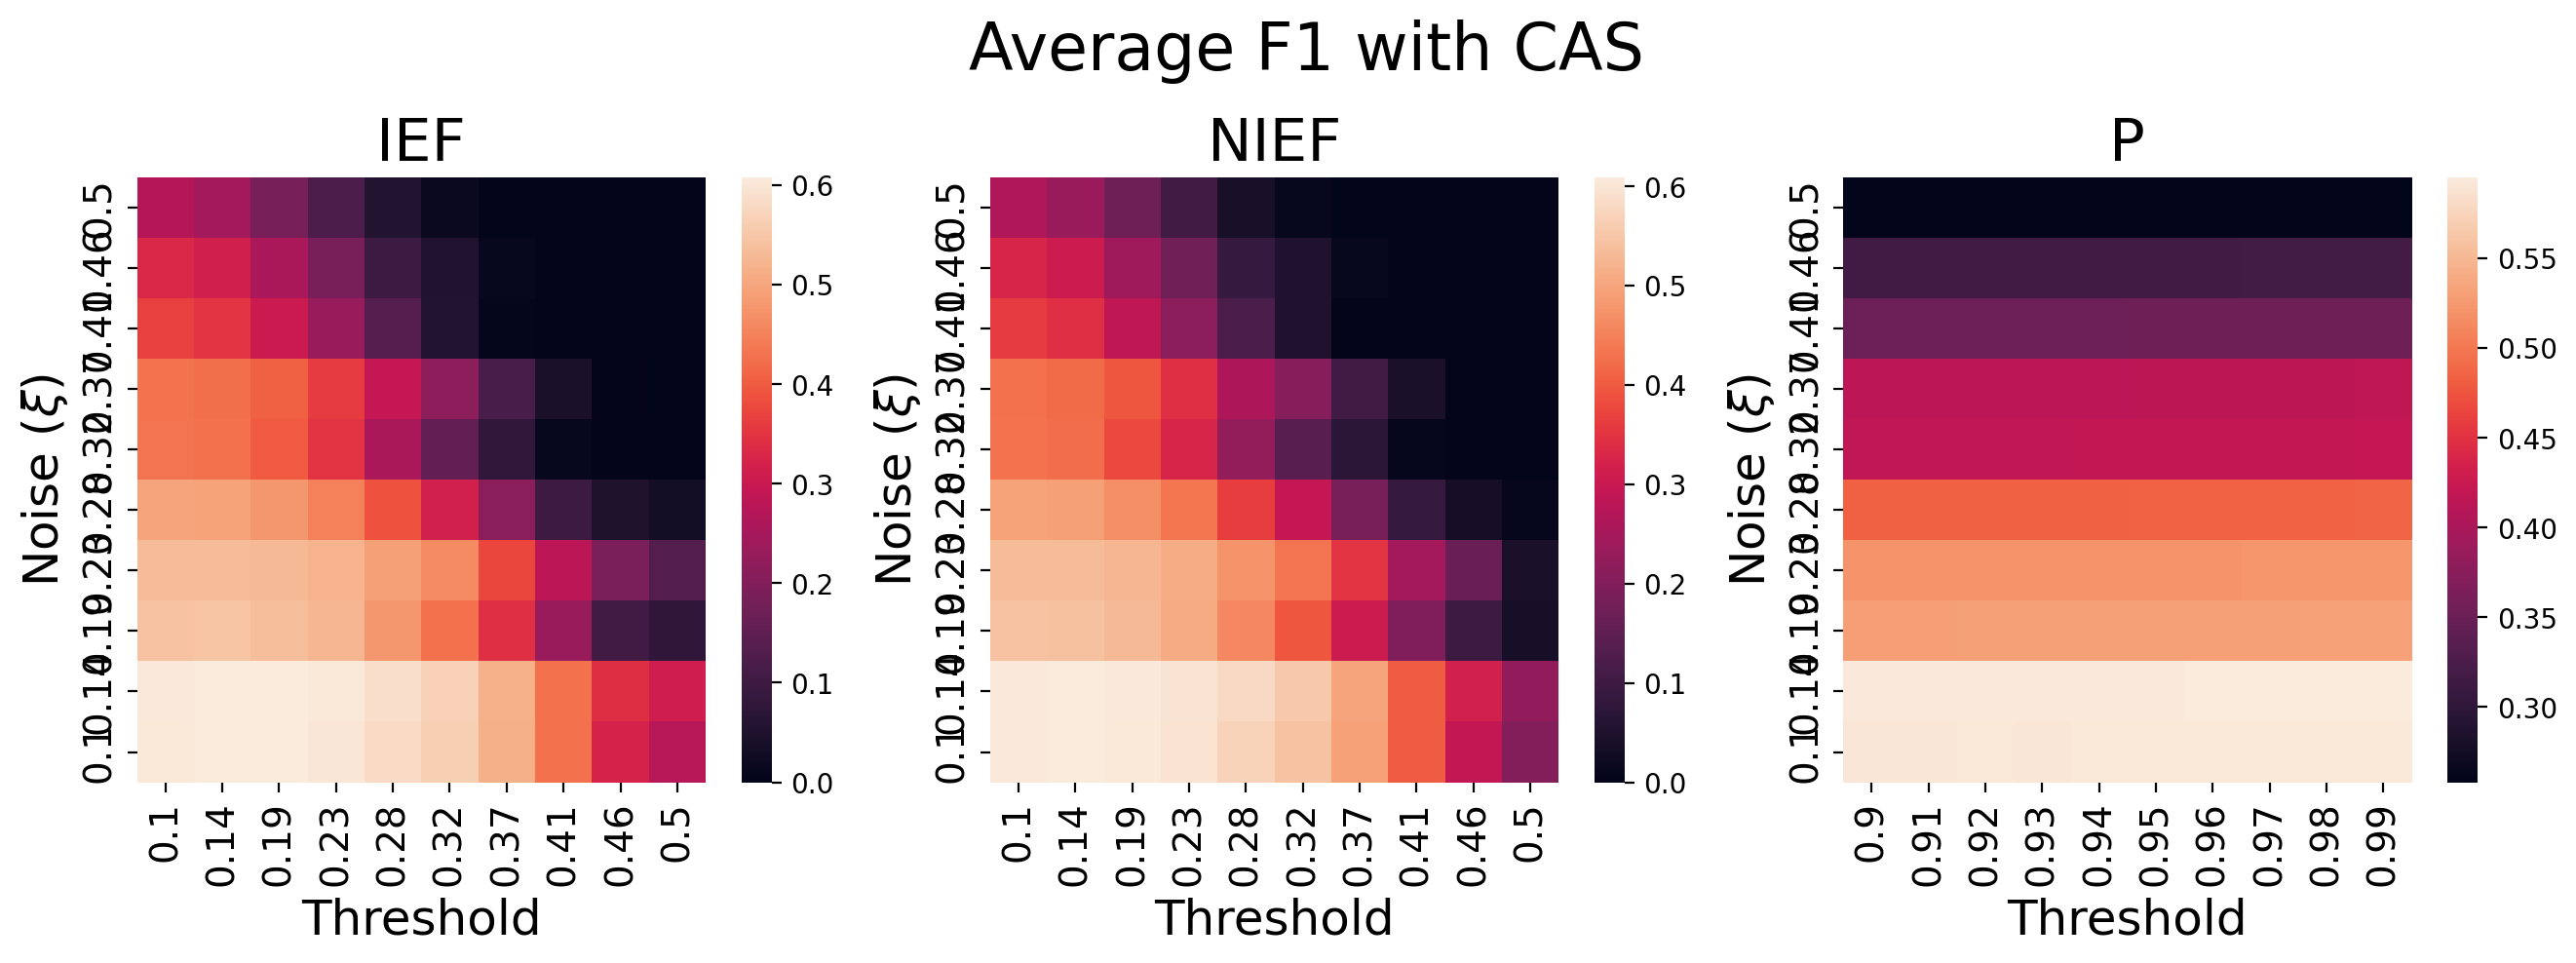

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4.5))
fig.subplots_adjust(top=0.8)  # Make room for suptitle

sns.heatmap(
    np.flip(np.mean(ief_f1s, axis=(2, 3)), axis=0),
    xticklabels=ief_thresholds,
    yticklabels=XIS[::-1],
    # annot=True,
    # fmt=".2f",
    ax=axs[0],
)
axs[0].set_xlabel(r"Threshold", fontsize=18)
axs[0].set_ylabel(r"Noise ($\xi$)", fontsize=18)
axs[0].tick_params(labelsize=14)
axs[0].set_title("IEF", fontsize=22)

sns.heatmap(
    np.flip(np.mean(nief_f1s, axis=(2, 3)), axis=0),
    xticklabels=ief_thresholds,
    yticklabels=XIS[::-1],
    # annot=True,
    # fmt=".2f",
    ax=axs[1],
)
axs[1].set_xlabel(r"Threshold", fontsize=18)
axs[1].set_ylabel(r"Noise ($\xi$)", fontsize=18)
axs[1].tick_params(labelsize=14)
axs[1].set_title("NIEF", fontsize=22)

sns.heatmap(
    np.flip(np.mean(p_f1s, axis=(2, 3)), axis=0),
    xticklabels=p_thresholds,
    yticklabels=XIS[::-1],
    # annot=True,
    # fmt=".2f",
    ax=axs[2],
)
axs[2].set_xlabel(r"Threshold", fontsize=18)
axs[2].set_ylabel(r"Noise ($\xi$)", fontsize=18)
axs[2].tick_params(labelsize=14)
axs[2].set_title("P", fontsize=22)

plt.suptitle("Average F1 with CAS", fontsize=24, y=0.98)
fig.set_dpi(200)
# fig.savefig("outlier-aucs.png", bbox_inches="tight")

# Real Graphs
Test the effect of the threshold on some real world graph datasets with ground truth communities.
We again hope to see that larger thresholds lead to more outliers and a more correct non-outlier clustering.

In [3]:
def load_graph(name):
    adjacency = sp.load_npz(f"data/{name}_adjacency.npz")
    try:
        labels = np.load(f"data/{name}_labels.npy")
        labels_indptr, labels_indices, labels_data = CAS.cas_._labels_array_to_matrix(
            labels
        )
        labels = sp.csr_matrix(
            (labels_data, labels_indices, labels_indptr),
            shape=(len(labels_indptr) - 1, len(labels)),
        )
        labels.data[:] = True
    except FileNotFoundError as e:
        try:
            labels = sp.load_npz(f"data/{name}_labels.npz")
        except FileNotFoundError as e:
            raise ValueError("Can't find labels file as npy or npz :(")
    return adjacency, labels

In [10]:
graphs = ["football", "eu-core", "as", "cora", "amazon", "dblp"]
ief_thresholds = np.linspace(0.2, 0.7, 20)
# p_thresholds = np.linspace(0.9, 0.999, 10)

# Store (Cluster F1, Non-Outlier Cluster F1, % Outlier) in first axis, theshold in second axis, REP in third axis
ief = np.empty((len(graphs), 3, len(ief_thresholds)))
nief = np.empty((len(graphs), 3, len(ief_thresholds)))
ecg = np.empty((len(graphs), 3, len(ief_thresholds)))
baseline = np.empty((len(graphs), 2))

for i, name in enumerate(graphs):
    print(name)
    adjacency, labels = load_graph(name)
    n = adjacency.shape[0]
    ecgo = ECG()
    ecgo.fit_predict(adjacency)
    predict = EgoSplit(local_clustering="CC", global_clustering=ECG()).fit_predict(
        adjacency
    )

    baseline[i, 0] = ce.cluster_f1s(labels, predict)
    baseline[i, 1] = ce.cluster_f1s(labels, predict, drop_outliers=True)

    print("CAS PostProcessing")
    with tqdm(total=len(ief_thresholds) * 3) as pbar:
        for j, t in enumerate(ief_thresholds):
            cas_predict = CAS.CASPostProcesser(
                score="ief", threshold=t, only_remove=False
            ).fit_predict(predict, adjacency)
            ief[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            ief[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            ief[i, 2, j] = np.sum(cas_predict.getnnz(0) == 0) / n
            pbar.update()

            cas_predict = CAS.CASPostProcesser(
                score="nief", threshold=t, only_remove=False
            ).fit_predict(predict, adjacency)
            nief[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            nief[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            nief[i, 2, j] = np.sum(cas_predict.getnnz(0) == 0) / n
            pbar.update()

            cas_predict = CAS.CASPostProcesser(
                score="ief", threshold=t, only_remove=False
            ).fit_predict(predict, ecgo.weights)
            ecg[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            ecg[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            ecg[i, 2, j] = np.sum(cas_predict.getnnz(0) == 0) / n
            pbar.update()

football
CAS PostProcessing


100%|██████████| 30/30 [00:01<00:00, 23.28it/s]


eu-core
CAS PostProcessing


100%|██████████| 30/30 [00:03<00:00,  9.59it/s]


as
CAS PostProcessing


100%|██████████| 30/30 [00:12<00:00,  2.47it/s]


cora
CAS PostProcessing


100%|██████████| 30/30 [00:32<00:00,  1.07s/it]


amazon
CAS PostProcessing


100%|██████████| 30/30 [11:19<00:00, 22.64s/it]


dblp
CAS PostProcessing


100%|██████████| 30/30 [15:27<00:00, 30.92s/it]


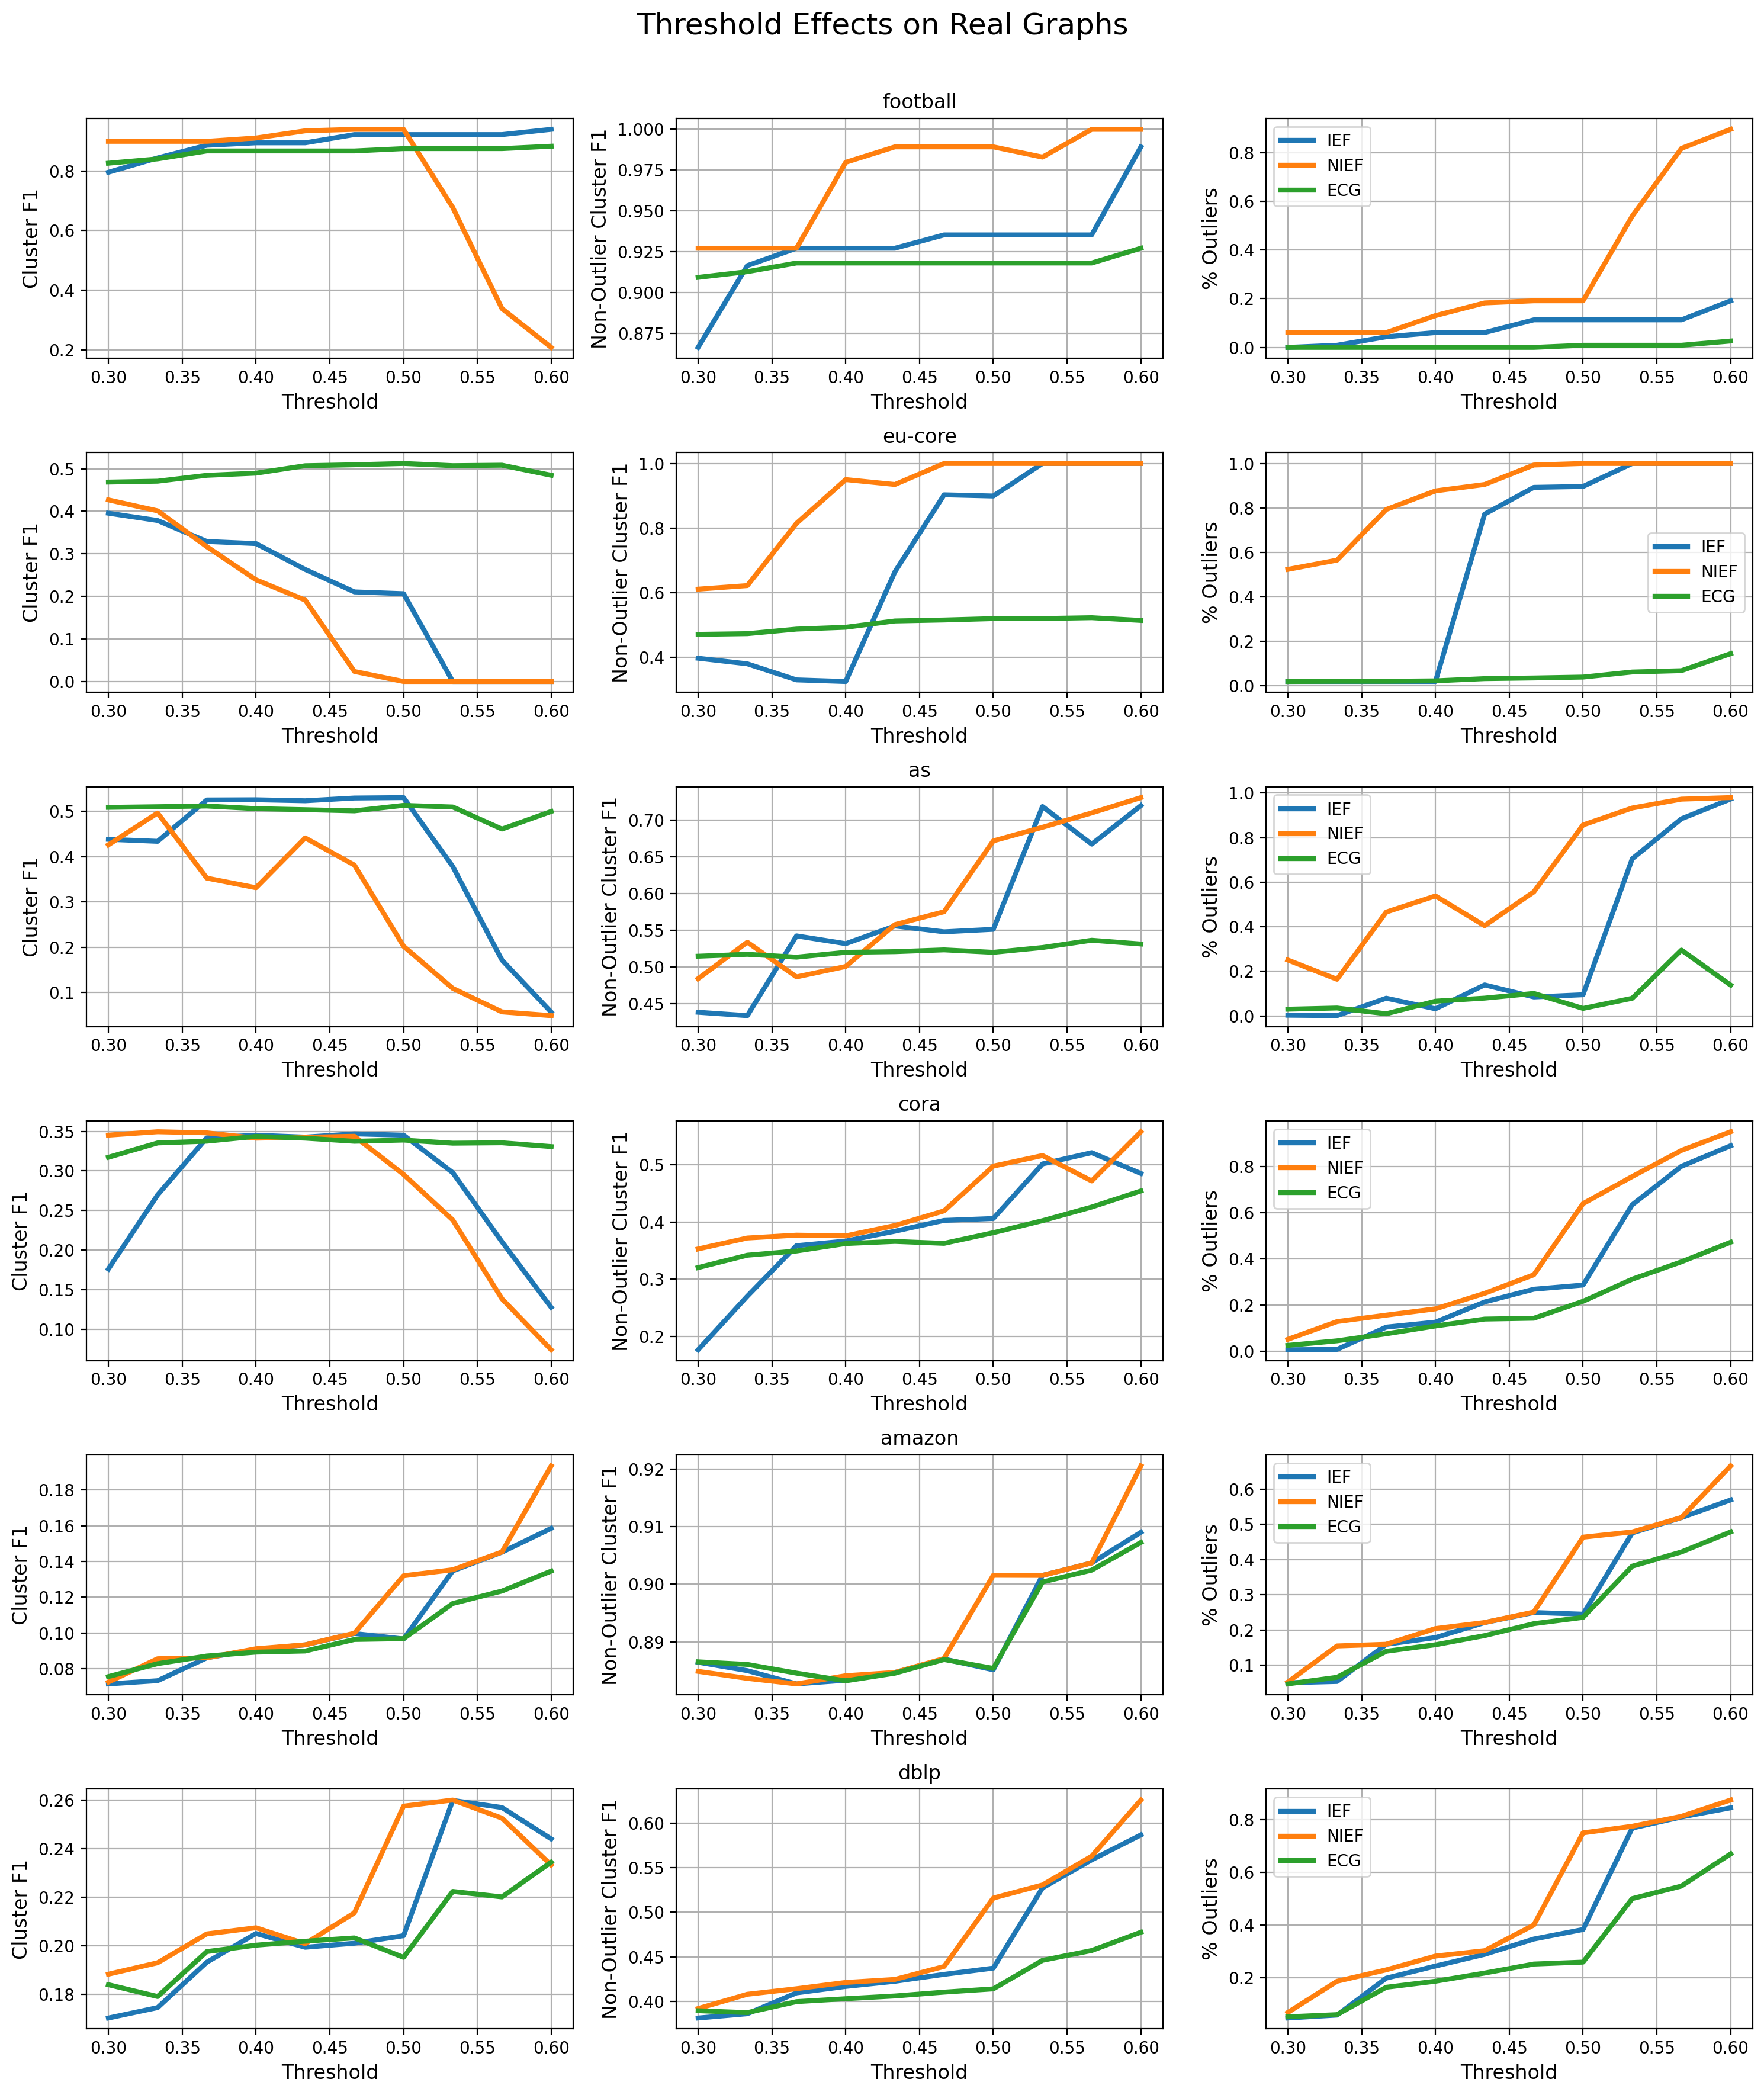

In [11]:
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]

fig, axs = plt.subplots(len(graphs), 3)
for i in range(len(graphs)):
    for j in range(3):
        lines = []
        # twy = axs[i,j].twiny()

        lines += axs[i, j].plot(
            ief_thresholds,
            ief[i, j, :],
            linewidth=3,
            label="IEF",
            c=colors[0],
        )
        lines += axs[i, j].plot(
            ief_thresholds,
            nief[i, j, :],
            linewidth=3,
            label="NIEF",
            c=colors[1],
        )
        lines += axs[i, j].plot(
            ief_thresholds,
            ecg[i, j, :],
            linewidth=3,
            label="ECG",
            c=colors[2],
        )
        # lines += twy.plot(
        #     p_thresholds, p[i, j, :], label="P", linewidth=3, c=colors[2]
        # )
        labels = [l.get_label() for l in lines]

        # Align tick marks, 5 looks good
        n_ticks = 6
        ief_ticks = np.linspace(np.min(ief_thresholds), np.max(ief_thresholds), n_ticks)
        axs[i, j].set_xticks(ief_ticks)
        # p_ticks = np.round(np.linspace(np.min(p_thresholds), 1, n_ticks), 2)
        # twy.set_xticks(p_ticks)
        axs[i, j].grid()

    axs[i, 0].set_ylabel("Cluster F1", fontsize=14)
    axs[i, 1].set_ylabel("Non-Outlier Cluster F1", fontsize=14)
    axs[i, 2].set_ylabel("% Outliers", fontsize=14)
    axs[i, 0].set_xlabel("Threshold", fontsize=14)
    axs[i, 1].set_xlabel("Threshold", fontsize=14)
    axs[i, 2].set_xlabel("Threshold", fontsize=14)
    axs[i, 2].legend(lines, labels)
    axs[i, 1].set_title(graphs[i], fontsize=16)
plt.suptitle(
    f"Threshold Effects on Real Graphs",
    fontsize=18,
)
fig = plt.gcf()
fig.set_size_inches(15, 3 * len(graphs))
fig.set_dpi(200)
fig.tight_layout()
fig.subplots_adjust(top=0.93)  # Make room for suptitle

## Internal cluster quality metrics
Check that CAS-Postprocessing improves the quality of each cluster based on some internal metrics of cluster quality.
We hope that the clusters "look-better" after post-processing.

In [5]:
t = 0.4
graphs = ["football", "eu-core", "as", "cora", "amazon", "dblp"]
data = np.empty((len(graphs), 6, 6))
for i, name in enumerate(graphs):
    print(name)
    adjacency, labels = load_graph(name)
    print("\tFitting Egosplit")
    predict = EgoSplit(local_clustering="CC", global_clustering=ECG()).fit_predict(
        adjacency
    )
    print("\tFitting ECG")
    ecgo = ECG()
    ecgo.fit_predict(adjacency)

    # predict = CAS.labels_array_to_matrix(ecgo.fit_predict(adjacency))
    predict_conductance = np.nanmean(ce.conductance(adjacency, predict))
    predict_cc = np.nanmean(ce.clustering_coefficient(adjacency, predict))
    predict_density = np.nanmean(ce.density(adjacency, predict))
    predict_cut_ratio = np.nanmean(ce.cut_ratio(adjacency, predict))
    predict_expansion = np.nanmean(ce.expansion(adjacency, predict))
    predict_modularity = np.nanmean(ce.modularity(adjacency, predict))

    print("\tCAS-IEF")
    ief_rec = CAS.CASPostProcesser(
        score="ief", threshold=t, only_remove=False
    ).fit_predict(predict, adjacency)
    ief_one = CAS.CASPostProcesser(
        score="ief", threshold=t, only_remove=False, max_rounds=1
    ).fit_predict(predict, adjacency)

    print("\tCAS-NIEF")
    nief_rec = CAS.CASPostProcesser(
        score="nief", threshold=t, only_remove=False
    ).fit_predict(predict, adjacency)
    nief_one = CAS.CASPostProcesser(
        score="nief", threshold=t, only_remove=False, max_rounds=1
    ).fit_predict(predict, adjacency)

    print("\tCAS-ECG")
    ecg_rec = CAS.CASPostProcesser(
        score="ief", threshold=t, only_remove=False
    ).fit_predict(predict, adjacency)
    ecg_one = CAS.CASPostProcesser(
        score="ief", threshold=t, only_remove=False, max_rounds=1
    ).fit_predict(predict, ecgo.weights)

    for j, cas in enumerate([ief_rec, ief_one, nief_rec, nief_one, ecg_rec, ecg_one]):
        cas_conductance = np.nanmean(ce.conductance(adjacency, cas))
        cas_cc = np.nanmean(ce.clustering_coefficient(adjacency, cas))
        cas_density = np.nanmean(ce.density(adjacency, cas))
        cas_cut_ratio = np.nanmean(ce.cut_ratio(adjacency, cas))
        cas_expansion = np.nanmean(ce.expansion(adjacency, cas))
        cas_modularity = np.nanmean(ce.modularity(adjacency, cas))

        data[i, j, 0] = cas_density - predict_density
        data[i, j, 1] = cas_cc - predict_cc
        data[i, j, 2] = cas_modularity - predict_modularity
        data[i, j, 3] = cas_conductance - predict_conductance
        data[i, j, 4] = cas_expansion - predict_expansion
        data[i, j, 5] = cas_cut_ratio - predict_cut_ratio

football
	Fitting Egosplit
	Fitting ECG
	CAS-IEF
	CAS-NIEF
	CAS-ECG
eu-core
	Fitting Egosplit
	Fitting ECG
	CAS-IEF
	CAS-NIEF
	CAS-ECG
as
	Fitting Egosplit
	Fitting ECG
	CAS-IEF
	CAS-NIEF
	CAS-ECG
cora
	Fitting Egosplit
	Fitting ECG
	CAS-IEF
	CAS-NIEF
	CAS-ECG
amazon
	Fitting Egosplit
	Fitting ECG
	CAS-IEF
	CAS-NIEF
	CAS-ECG
dblp
	Fitting Egosplit
	Fitting ECG
	CAS-IEF
	CAS-NIEF
	CAS-ECG


In [6]:
print(f"         | Density |   CC   | Modularity | Conductance | Cut Ratio | Expansion")
for j, score in enumerate(
    ["IEF REC", "IEF ONE", "NIEF REC", "NIEF ONE", "ECG REC", "ECG ONE"]
):
    print()
    print(f"{score:.14s}")
    for i, name in enumerate(graphs):
        print(
            f"{name:8s} | {data[i, j, 0]:7.3f} | {data[i, j, 1]:6.3f} | {data[i, j, 2]:10.3f} | {data[i, j, 3]:11.3f} | {data[i,j,5]:9.3f} | {data[i, j, 4]:9.3f}"
        )

         | Density |   CC   | Modularity | Conductance | Cut Ratio | Expansion

IEF REC
football |   0.106 |  0.100 |     -0.000 |      -0.073 |    -0.007 |    -0.678
eu-core  |   0.011 |  0.034 |     -0.003 |      -0.148 |    -0.006 |    -4.523
as       |  -0.094 | -0.162 |      0.001 |      -0.133 |    -0.000 |    -7.483
cora     |  -0.120 | -0.119 |      0.000 |      -0.217 |    -0.000 |    -5.680
amazon   |  -0.070 | -0.069 |      0.000 |      -0.088 |    -0.000 |    -1.372
dblp     |  -0.160 | -0.130 |      0.000 |      -0.168 |    -0.000 |    -4.422

IEF ONE
football |   0.087 |  0.077 |      0.000 |      -0.071 |    -0.007 |    -0.660
eu-core  |   0.004 | -0.001 |     -0.001 |      -0.025 |    -0.003 |    -2.328
as       |  -0.103 | -0.169 |      0.001 |      -0.070 |    -0.000 |    -7.382
cora     |  -0.157 | -0.130 |      0.000 |      -0.077 |    -0.000 |    -5.410
amazon   |  -0.081 | -0.077 |      0.000 |      -0.040 |    -0.000 |    -1.214
dblp     |  -0.210 | -0.135 |     